In [1]:
#IMPORTANDO BIBLIOTECAS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import scipy.stats as stats


In [2]:
#IMPORTANDO DADOS 
df_alti = pd.read_excel('diferenca_altimetria_clean.xlsx')

#DATAFRAME DADOS ORIGINAIS (DF_ALTI)
col_list = df_alti.columns.tolist()

#DATAFRAME DAS DIFERENÇAS (DF_DIFF)
trats = col_list[2:]
const = 0.138

df_diff = pd.DataFrame(index=df_alti.index)

for trat in trats:
    df_diff[f"{trat}_diff"] = df_alti[trat] - df_alti['NIV'] + const

#DATAFRAME DAS DIFERENÇAS EM MODULO (DF_DIFF_ABS)
df_diff_abs = df_diff.abs()

print("\ndf_alti.head():\n", df_alti.head())
print("\ndf_diff.head():\n", df_diff.head())
print("\ndf_diff_abs.head():\n", df_diff_abs.head())


df_alti.head():
    PT       NIV         V1        V2         V3
0   1  804.9540  804.81171  804.8190  804.78698
1   2  804.9360  804.81283  804.8208  804.78687
2   3  804.9375  804.79095  804.8129  804.78312
3   4  804.9375  804.78145  804.8065  804.77104
4   5  804.9090  804.76936  804.7909  804.74439

df_diff.head():
    V1_diff  V2_diff  V3_diff
0 -0.00429   0.0030 -0.02902
1  0.01483   0.0228 -0.01113
2 -0.00855   0.0134 -0.01638
3 -0.01805   0.0070 -0.02846
4 -0.00164   0.0199 -0.02661

df_diff_abs.head():
    V1_diff  V2_diff  V3_diff
0  0.00429   0.0030  0.02902
1  0.01483   0.0228  0.01113
2  0.00855   0.0134  0.01638
3  0.01805   0.0070  0.02846
4  0.00164   0.0199  0.02661


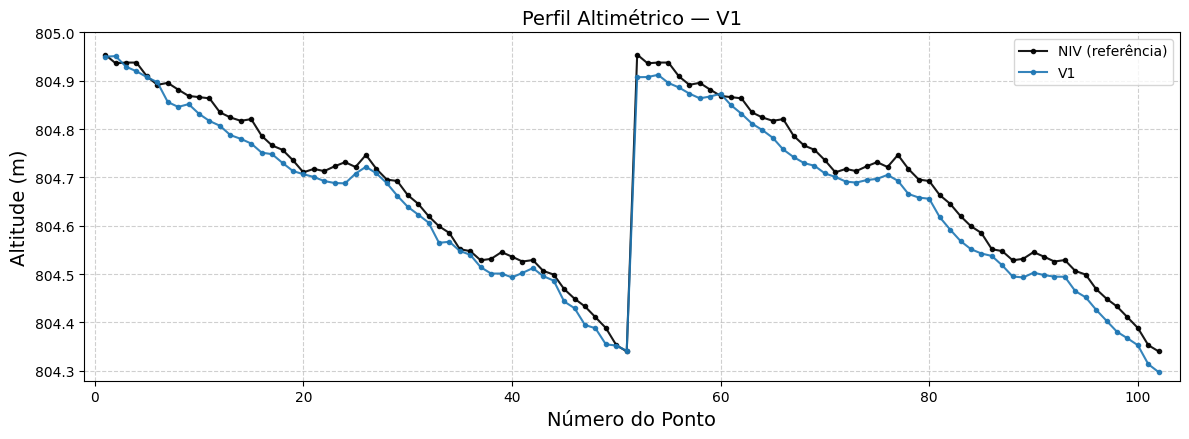

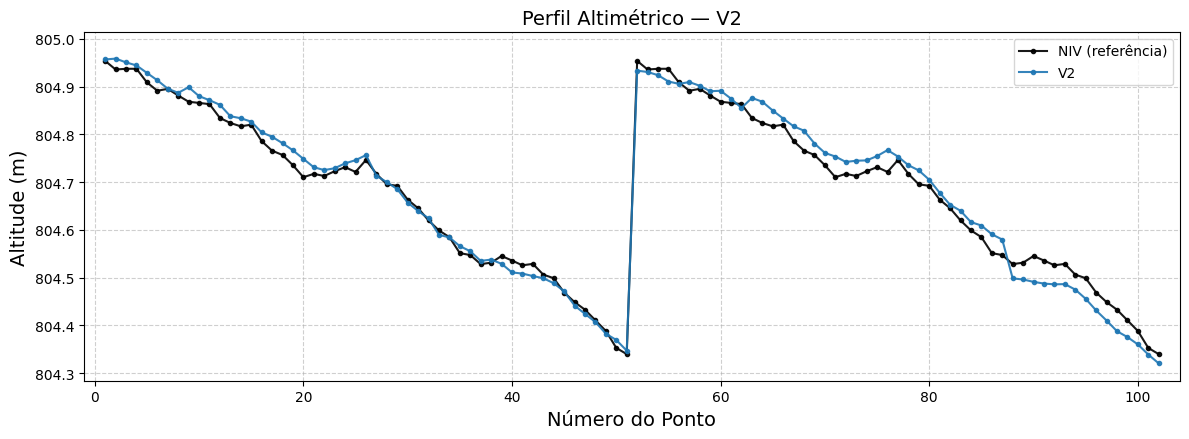

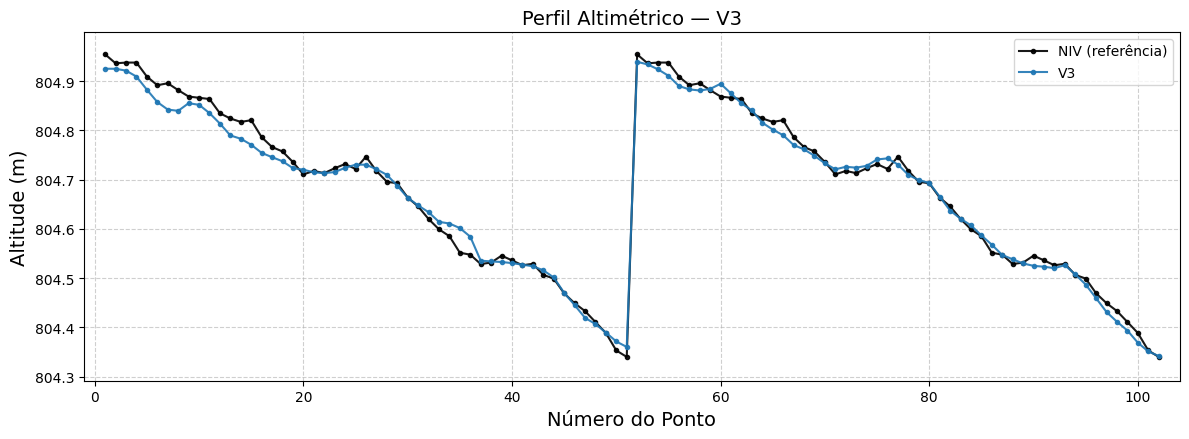

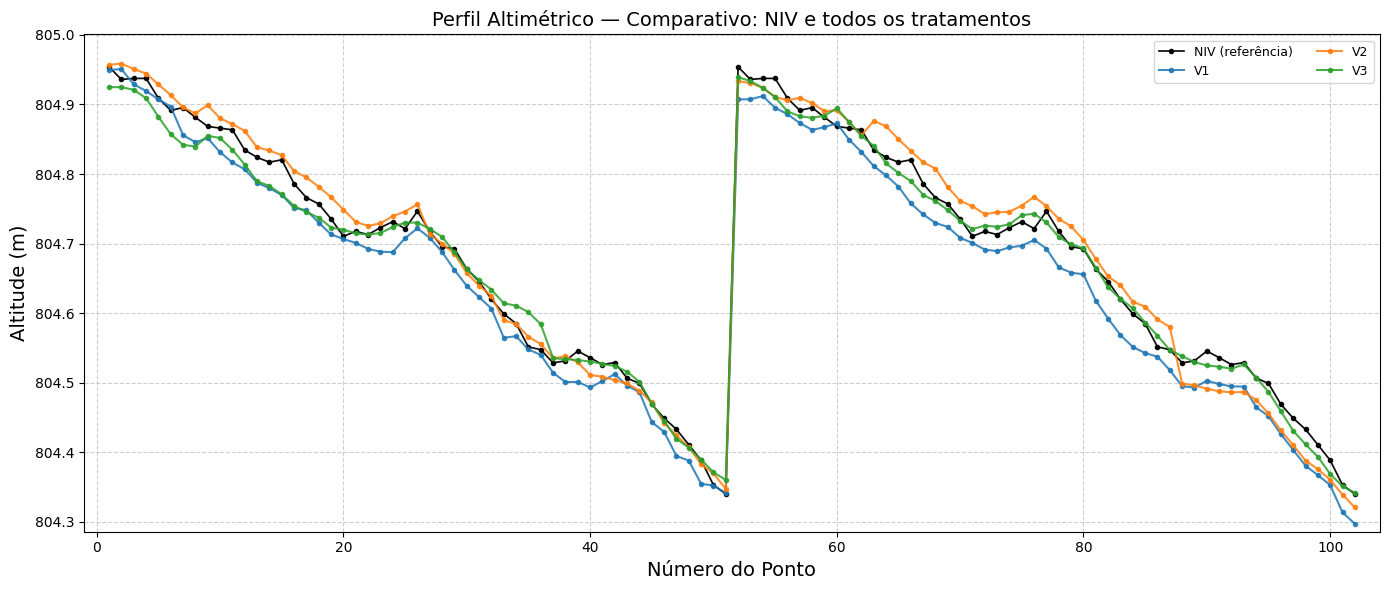

In [3]:
### GRAFICO DE PERFIL
for trat in trats:
    df_alti[trat] = df_alti[trat] + const

# ----------------------------------------
# --- VARIÁVEIS DE CONFIGURAÇÃO VISUAL ---
# ----------------------------------------

# --- Tamanho das bolinhas ---
markersize_ref = 3      # NIV
markersize_sel = 3      # Tratamento (cada coluna)
# Se quiser alterar, basta mudar esses valores

# --- Espaçamento / margens manual nos eixos ---
x_margin_frac = 0.02    # fração do eixo X
y_margin_frac = 0.05    # fração do eixo Y
# Se quiser alterar, basta mudar esses valores

# ----------------------------------------
# --- FUNÇÕES DE ESCALA ---
# ----------------------------------------
def escala_percentil(z, p_low=2, p_high=98, margin_frac=0.05):
    """Define limites verticais com base nos percentis e uma margem relativa."""
    y_low = np.percentile(z, p_low)
    y_high = np.percentile(z, p_high)
    y_range = y_high - y_low if (y_high - y_low) != 0 else 1.0
    ymin = y_low - margin_frac * y_range
    ymax = y_high + margin_frac * y_range
    return ymin, ymax

def escala_combinada(arrays, metodo='percentil', margin_frac=y_margin_frac):
    combined = np.concatenate([np.asarray(a).ravel() for a in arrays])
    if metodo == 'percentil':
        ymin, ymax = escala_percentil(combined, margin_frac=margin_frac)
        return ymin, ymax
    else:
        raise ValueError("Método inválido: use 'percentil'")

# ----------------------------------------
# --- FUNÇÃO DE PLOT NIV vs UMA COLUNA ---
# ----------------------------------------
def plot_niv_vs_trat(df, trat_col, metodo='percentil', nome=None, save=False):
    ref_col = df.columns[1]  # NIV
    y_ref = df[ref_col].to_numpy()
    y_sel = df[trat_col].to_numpy()
    x = np.arange(1, len(y_ref) + 1)

    # calcula limites considerando ambos os conjuntos
    ymin, ymax = escala_combinada([y_ref, y_sel], metodo=metodo, margin_frac=y_margin_frac)

    fig, ax = plt.subplots(figsize=(12, 4.5))

    # --- Plot referência (NIV) ---
    ax.plot(
        x, y_ref,
        marker='o',
        markersize=markersize_ref,   # <- ajuste tamanho da bolinha aqui
        linestyle='-',
        color='black',
        label=f"{ref_col} (referência)",
        alpha=0.9
    )

    # --- Plot seleção (coluna trat) ---
    ax.plot(
        x, y_sel,
        marker='o',
        markersize=markersize_sel,   # <- ajuste tamanho da bolinha aqui
        linestyle='-',
        color='C0',
        label=f"{trat_col}",
        alpha=0.9
    )

    # --- Margens adicionais nos eixos ---
    x_span = len(x)
    ax.set_xlim(1 - x_margin_frac*x_span, len(x) + x_margin_frac*x_span)
    y_span = ymax - ymin
    ax.set_ylim(ymin - y_margin_frac*y_span, ymax + y_margin_frac*y_span)

    # --- Título, rótulos e grid ---
    titulo = f"Perfil Altimétrico — {trat_col}" if nome is None else nome
    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel('Número do Ponto', fontsize=14)
    ax.set_ylabel('Altitude (m)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='best')
    plt.tight_layout()

    if save:
        fname = f"perfil_NIV_vs_{trat_col}.png"
        fig.savefig(fname, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close(fig)

# ----------------------------------------
# --- Gerar gráficos para cada coluna ---
# ----------------------------------------
for trat in trats:
    plot_niv_vs_trat(df_alti, trat, metodo='percentil', save=True)

# ----------------------------------------
# --- Gráfico comparativo final: NIV vs todas as colunas ---
# ----------------------------------------
def plot_comparativo_todos(df, trats_list, metodo='percentil', save=False):
    ref_col = df.columns[1]
    y_ref = df[ref_col].to_numpy()
    x = np.arange(1, len(y_ref) + 1)

    fig, ax = plt.subplots(figsize=(14, 6))

    # --- NIV ---
    ax.plot(x, y_ref, marker='o', markersize=markersize_ref, linestyle='-', color='black',
            linewidth=1.25, label=f"{ref_col} (referência)", alpha=0.95)

    # --- Todos os tratamentos ---
    colors_palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, trat in enumerate(trats_list):
        color = colors_palette[i % len(colors_palette)]
        y = df[trat].to_numpy()
        ax.plot(x, y, marker='o', markersize=markersize_sel, linestyle='-', label=f"{trat}",
                color=color, alpha=0.85)

    # Limites combinados
    arrays = [y_ref] + [df[t].to_numpy() for t in trats_list]
    ymin, ymax = escala_combinada(arrays, metodo=metodo, margin_frac=y_margin_frac)
    x_span = len(x)
    y_span = ymax - ymin
    ax.set_xlim(1 - x_margin_frac*x_span, len(x) + x_margin_frac*x_span)
    ax.set_ylim(ymin - y_margin_frac*y_span, ymax + y_margin_frac*y_span)

    ax.set_title("Perfil Altimétrico — Comparativo: NIV e todos os tratamentos", fontsize=14)
    ax.set_xlabel('Número do Ponto', fontsize=14)
    ax.set_ylabel('Altitude (m)', fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(ncol=2, fontsize=9, loc='best')

    plt.tight_layout()
    if save:
        fig.savefig("perfil_comparativo_todos.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Chamada do comparativo
plot_comparativo_todos(df_alti, trats, metodo='percentil', save=True)


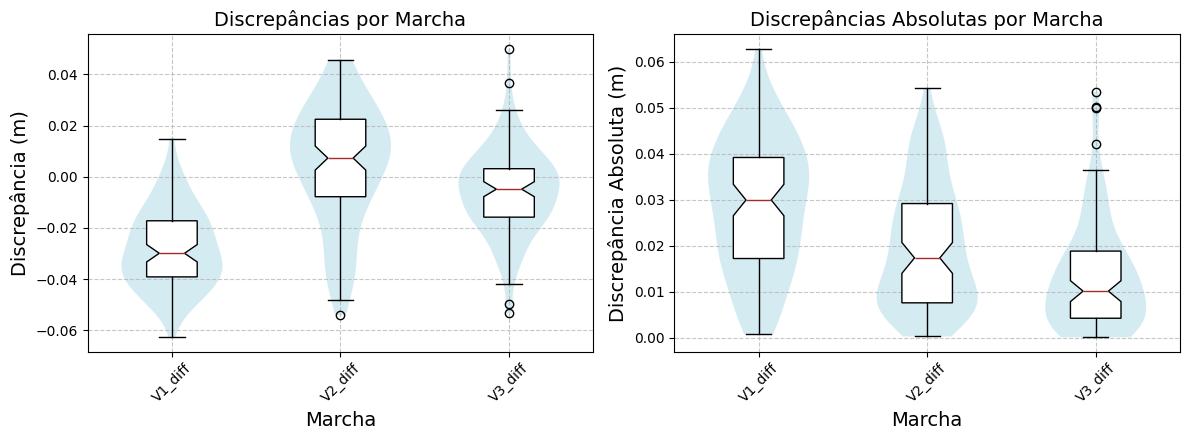

In [4]:
### GRAFICO DE BOXPLOT

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# DISCREPANCIAS
data_diff = [df_diff[col] for col in df_diff.columns]
positions_diff = np.arange(1, len(df_diff.columns) + 1)

# VIOLINGRAPH
parts1 = ax1.violinplot(data_diff, positions=positions_diff, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts1['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

# BOXPLOT
ax1.boxplot(data_diff, positions=positions_diff,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax1.set_title('Discrepâncias por Marcha', fontsize=14)
ax1.set_ylabel('Discrepância (m)', fontsize=14)
ax1.set_xlabel('Marcha', fontsize=14)
ax1.set_xticks(positions_diff)
ax1.set_xticklabels(df_diff.columns, rotation=45)
ax1.grid(True, linestyle='--', alpha=0.7)

# DISCREPANCIAS ABSOLUTAS
data_diff_abs = [df_diff_abs[col] for col in df_diff_abs.columns]
positions_abs = list(range(1, len(df_diff.columns) + 1))

parts2 = ax2.violinplot(data_diff_abs, positions=positions_abs, widths=0.6,
                        showmeans=False, showmedians=False, showextrema=False)
for pc in parts2['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.5)
    pc.set_edgecolor('none')

ax2.boxplot(data_diff_abs, positions=positions_abs,
            notch=True, patch_artist=True,
            boxprops=dict(facecolor='white', color='black'),
            medianprops=dict(color='brown'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))

ax2.set_title('Discrepâncias Absolutas por Marcha', fontsize=14)
ax2.set_ylabel('Discrepância Absoluta (m)', fontsize=14)
ax2.set_xlabel('Marcha', fontsize=14)
ax2.set_xticks(positions_abs)
ax2.set_xticklabels(df_diff_abs.columns, rotation=45)
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('boxplot_com_fundo_violin.png', dpi=300, bbox_inches='tight')
plt.show()



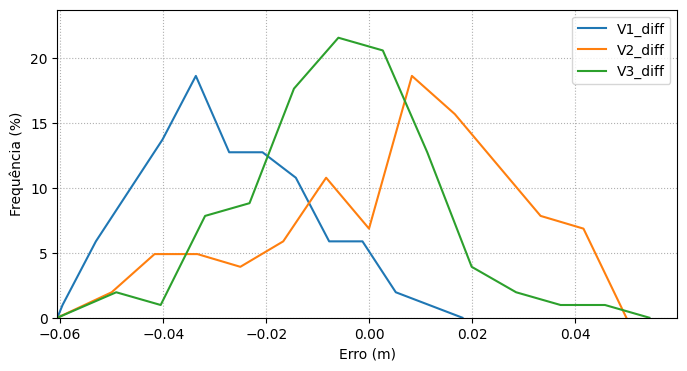

In [19]:
### GRÁFICO DE DISTRIBUIÇÃO DE FREQUÊNCIA

bins = 12

def CalcHistLin(data, nbins):
    count, bins_values = np.histogram(data, bins=nbins)
    total_count = sum(count)
    percent_value = (count / total_count) * 100
    bins_center = 0.5*(bins_values[:-1] + bins_values[1:])
    return bins_center, percent_value


# Calcula histogramas
bin_v1, freq_v1 = CalcHistLin(df_diff['V1_diff'], bins)
bin_v2, freq_v2 = CalcHistLin(df_diff['V2_diff'], bins)
bin_v3, freq_v3 = CalcHistLin(df_diff['V3_diff'], bins)

# --- Novo: criando ponto inicial correto (xmin_global, 0) ---
xmin_global = min(bin_v1.min(), bin_v2.min(), bin_v3.min())-0.001

# Inserir esse ponto no início das curvas
bin_v1 = np.insert(bin_v1, 0, xmin_global-0.00001)
freq_v1 = np.insert(freq_v1, 0, 0)

bin_v2 = np.insert(bin_v2, 0, xmin_global-0.00001)
freq_v2 = np.insert(freq_v2, 0, 0)

bin_v3 = np.insert(bin_v3, 0, xmin_global-0.00001)
freq_v3 = np.insert(freq_v3, 0, 0)

# --- Criar ponto final artificial ---
def add_final_point(x, y):
    last_x = 2*x[-1] - x[-2]
    x = np.append(x, last_x)
    y = np.append(y, 0)
    return x, y

bin_v1, freq_v1 = add_final_point(bin_v1, freq_v1)
bin_v2, freq_v2 = add_final_point(bin_v2, freq_v2)
bin_v3, freq_v3 = add_final_point(bin_v3, freq_v3)


# --- Plot ---
plt.figure(figsize=(8,4))
plt.plot(bin_v1, freq_v1, label='V1_diff')
plt.plot(bin_v2, freq_v2, label='V2_diff')
plt.plot(bin_v3, freq_v3, label='V3_diff')

plt.xlabel('Erro (m)')
plt.ylabel('Frequência (%)')

plt.ylim(0, max(np.concatenate((freq_v1, freq_v2, freq_v3))) * 1.1)
plt.xlim(xmin_global, max(np.concatenate((bin_v1, bin_v2, bin_v3))) * 1.1)

plt.grid(True, linestyle=':')
plt.legend()
plt.show()


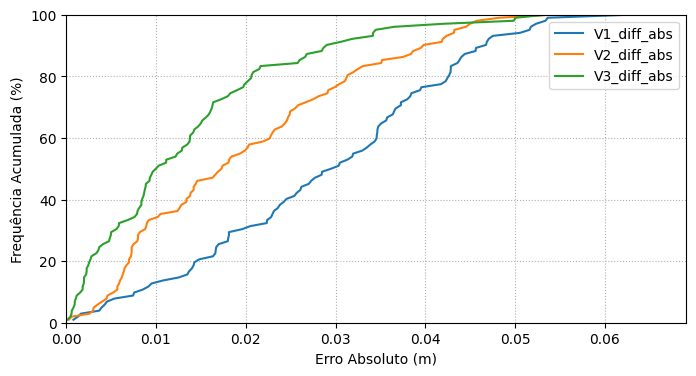

In [ ]:
### GRÀFICO - FREQUÊNCIA ACUMULADA ABSOLUTA

def CalcAcumFreq(serie):
    data_sorted = np.sort(serie)
    n = len(data_sorted)
    cum_freq = np.arange(1, n+1) / n * 100
    return data_sorted, cum_freq


data_sort_V1a, cum_V1a = CalcAcumFreq(df_diff_abs['V1_diff'])
data_sort_V2a, cum_V2a = CalcAcumFreq(df_diff_abs['V2_diff'])
data_sort_V3a, cum_V3a = CalcAcumFreq(df_diff_abs['V3_diff'])

plt.figure(figsize=(8,4))

plt.plot(data_sort_V1a, cum_V1a, label='V1_diff_abs')
plt.plot(data_sort_V2a, cum_V2a, label='V2_diff_abs')
plt.plot(data_sort_V3a, cum_V3a, label='V3_diff_abs')

plt.xlabel('Erro Absoluto (m)', loc='center')
plt.ylabel('Frequência Acumulada (%)')

plt.ylim(0, 100)

# aqui você deve usar os ABSOLUTOS também, senão fica errado
plt.xlim(0, max(np.concatenate((data_sort_V1a, data_sort_V2a, data_sort_V3a))) * 1.1)

plt.grid(True, linestyle=':')
plt.legend()
plt.show()


In [21]:
# TESTE DE NORMALIDADE
import pandas as pd
from scipy.stats import shapiro

# --- FUNÇÃO ---
def testar_normalidade_df(df):
    resultados = []
    for col in df.columns:
        dados = df[col].dropna()  # remove valores nulos
        
        if len(dados) < 8:
            resultados.append((col, None, None, "Amostra muito pequena"))
            continue
        
        stat, p = shapiro(dados)
        resultado = "Normal (p > 0.05)" if p > 0.05 else "Não normal (p < 0.05)"
        resultados.append((col, stat, p, resultado))
    
    # Cria um DataFrame com os resultados
    df_result = pd.DataFrame(resultados, columns=["Coluna", "W", "p", "Resultado"])
    return df_result

# --- EXECUÇÃO ---
df_normalidade = testar_normalidade_df(df_diff)

# --- EXIBIÇÃO ---
print("===== RESULTADOS DO TESTE DE NORMALIDADE (Shapiro–Wilk) =====")
print(df_normalidade)

# --- OPCIONAL: salvar para Excel ---
df_normalidade.to_excel("teste_normalidade_shapiro.xlsx", index=False)



===== RESULTADOS DO TESTE DE NORMALIDADE (Shapiro–Wilk) =====
    Coluna         W         p              Resultado
0  V1_diff  0.985407  0.326118      Normal (p > 0.05)
1  V2_diff  0.964324  0.007429  Não normal (p < 0.05)
2  V3_diff  0.985956  0.357417      Normal (p > 0.05)


#### **Inicio Reunião 8** 😎

### Link pra apresentação:

https://docs.google.com/presentation/d/1ngW-qNjmy2pJUIkV2O6mYOkTPn0PK_pp/edit?usp=sharing&ouid=112142125592243547992&rtpof=true&sd=true


In [25]:
# ==========================================
# TESTES DE COMPARAÇÃO DE MÉDIAS (NÃO PARAMÉTRICOS)
# ==========================================
# Usando: Teste de Friedman + Testes de Wilcoxon pareados
# Base: df_diff com V1_diff, V2_diff, V3_diff (erros com sinal)
# ==========================================

from scipy.stats import friedmanchisquare, wilcoxon
import pandas as pd

# --- Teste de Friedman (comparação global entre os três grupos) ---
stat_friedman, p_friedman = friedmanchisquare(
    df_diff['V1_diff'],
    df_diff['V2_diff'],
    df_diff['V3_diff']
)

print("\n===== TESTE DE FRIEDMAN =====")
print(f"Estatística Q = {stat_friedman:.6f}")
print(f"p-valor = {p_friedman:.6f}")

if p_friedman < 0.05:
    print("→ Diferença significativa entre os grupos (p < 0.05).")
else:
    print("→ NÃO há diferença significativa entre os grupos (p ≥ 0.05).")

# --- Executa Wilcoxon automaticamente se o Friedman for significativo ---
pares = [
    ('V1', 'V2'),
    ('V1', 'V3'),
    ('V2', 'V3')
]

resultados_wilcoxon = []

if p_friedman < 0.05:
    print("\n===== TESTES DE WILCOXON (PÓS-TESTES) =====")
    for a, b in pares:
        stat_w, p_w = wilcoxon(df_diff_abs[f"{a}_diff"], df_diff_abs[f"{b}_diff"])
        resultado = {
            "Comparação": f"{a} × {b}",
            "Estatística W": stat_w,
            "p-valor": p_w,
            "Conclusão": "Diferença significativa" if p_w < 0.05 else "Sem diferença significativa"
        }
        resultados_wilcoxon.append(resultado)
        print(f"\nComparação {a} × {b}:")
        print(f"  Estatística W = {stat_w:.6f}")
        print(f"  p-valor = {p_w:.6f}")
        print(f"  → {resultado['Conclusão']}")
else:
    print("\nPós-testes de Wilcoxon não realizados (Friedman não significativo).")

# --- Armazenar tudo em um DataFrame (útil para exportar ao relatório) ---
df_resultados = pd.DataFrame(resultados_wilcoxon)
print("\n===== RESUMO DOS TESTES DE WILCOXON =====")
display(df_resultados)



===== TESTE DE FRIEDMAN =====
Estatística Q = 117.725490
p-valor = 0.000000
→ Diferença significativa entre os grupos (p < 0.05).

===== TESTES DE WILCOXON (PÓS-TESTES) =====

Comparação V1 × V2:
  Estatística W = 1284.000000
  p-valor = 0.000007
  → Diferença significativa

Comparação V1 × V3:
  Estatística W = 708.500000
  p-valor = 0.000000
  → Diferença significativa

Comparação V2 × V3:
  Estatística W = 1563.000000
  p-valor = 0.000385
  → Diferença significativa

===== RESUMO DOS TESTES DE WILCOXON =====


,Comparação,Estatística W,p-valor,Conclusão
0,V1 × V2,1284.0,7.411706e-06,Diferença significativa
1,V1 × V3,708.5,1.527157e-10,Diferença significativa
2,V2 × V3,1563.0,3.849987e-04,Diferença significativa


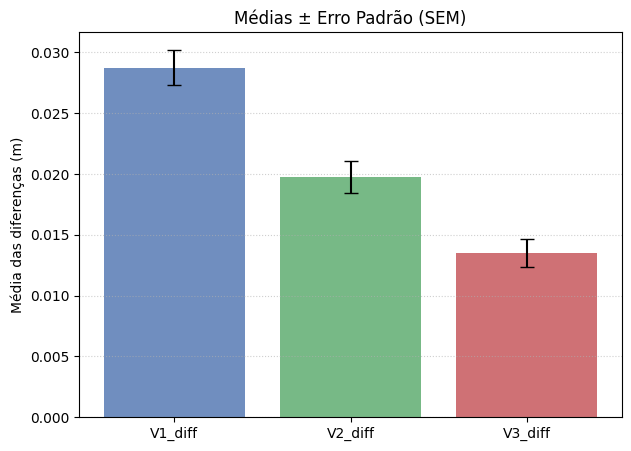

In [26]:
# ===============================
# 1. GRÁFICO DE MÉDIAS + ERRO PADRÃO
# ===============================

dados = df_diff_abs.copy()

medias = dados.mean()
sem = dados.sem()   # erro padrão da média

plt.figure(figsize=(7,5))
plt.bar(medias.index, medias.values, yerr=sem.values, capsize=5,
        color=["#4C72B0","#55A868","#C44E52"], alpha=0.8)

plt.ylabel("Média das diferenças (m)")
plt.title("Médias ± Erro Padrão (SEM)")
plt.grid(axis="y", linestyle=":", alpha=0.6)

plt.show()


O gráfico de médias ± SEM evidencia que os três métodos apresentam diferenças sistemáticas distintas. V1 apresenta um desvio médio negativo acentuado (≈ –2.8 cm), indicando um viés de subestimativa significativo. V2 possui o menor erro médio, com leve superestimativa (≈ +4 mm). V3 apresenta pequeno desvio negativo (≈ –5 mm).

Esses padrões são confirmados estatisticamente pelos testes de Friedman e Wilcoxon, que indicam diferença significativa entre todos os pares de métodos.

In [28]:
# ===============================
# 3. MATRIZ DE COMPARAÇÃO MÚLTIPLA (WILCOXON) — SEM COMBINATIONS
# ===============================

df = df_diff.copy()
colunas = df.columns.tolist()

resultados = []

# Dois loops simples para gerar todos os pares i < j
for i in range(len(colunas)):
    for j in range(i + 1, len(colunas)):
        c1 = colunas[i]
        c2 = colunas[j]

        # Teste de Wilcoxon para amostras pareadas
        w, p = stats.wilcoxon(df[c1], df[c2])
        conclusao = "Diferença significativa" if p < 0.05 else "Sem diferença"

        # Guarda os resultados
        resultados.append([f"{c1} × {c2}", w, p, conclusao])

# Converte para tabela
tabela = pd.DataFrame(
    resultados,
    columns=["Comparação", "W", "p-valor", "Conclusão"]
)

print("===== MATRIZ DE COMPARAÇÃO MÚLTIPLA (WILCOXON) =====")
display(tabela)


===== MATRIZ DE COMPARAÇÃO MÚLTIPLA (WILCOXON) =====


,Comparação,W,p-valor,Conclusão
0,V1_diff × V2_diff,89.0,2.440558e-17,Diferença significativa
1,V1_diff × V3_diff,300.5,8.189269e-15,Diferença significativa
2,V2_diff × V3_diff,1611.0,6.991209e-04,Diferença significativa


In [29]:
# ===============================
# 4. TESTE DE NEMENYI (PÓS-FRIEDMAN)
# ===============================

from math import sqrt

df = df_diff.copy()
k = df.shape[1]   # número de métodos (ex: 3)
n = df.shape[0]   # número de blocos (ex: N pontos)

# Ranking médio por linha
rankings = df.rank(axis=1)
R = rankings.mean()   # ranking médio de cada coluna

# Tabela de valores críticos q (α = 0.05)
q_criticos = {3: 2.343, 4: 2.569, 5: 2.728}

q = q_criticos[k]

# Critical Difference (CD)
CD = q * sqrt(k * (k + 1) / (6 * n))

print(f"Critical Difference (Nemenyi): {CD:.5f}\n")

# Criar pares usando dois loops, sem combinations
colunas = df.columns.tolist()
resultados = []

for i in range(len(colunas)):
    for j in range(i + 1, len(colunas)):
        c1 = colunas[i]
        c2 = colunas[j]

        diff = abs(R[c1] - R[c2])
        sig = "Significativo" if diff > CD else "Não significativo"

        resultados.append([f"{c1} × {c2}", diff, sig])

# Construir tabela
tabela_nemenyi = pd.DataFrame(
    resultados,
    columns=["Comparação", "Diferença Ranking", "Conclusão"]
)

print("===== TESTE DE NEMENYI =====")
display(tabela_nemenyi)


Critical Difference (Nemenyi): 0.32809

===== TESTE DE NEMENYI =====


,Comparação,Diferença Ranking,Conclusão
0,V1_diff × V2_diff,1.431373,Significativo
1,V1_diff × V3_diff,1.156863,Significativo
2,V2_diff × V3_diff,0.274510,Não significativo


===== GRUPOS COM LETRAS =====
V1_diff: A
V3_diff: BC
V2_diff: CCC


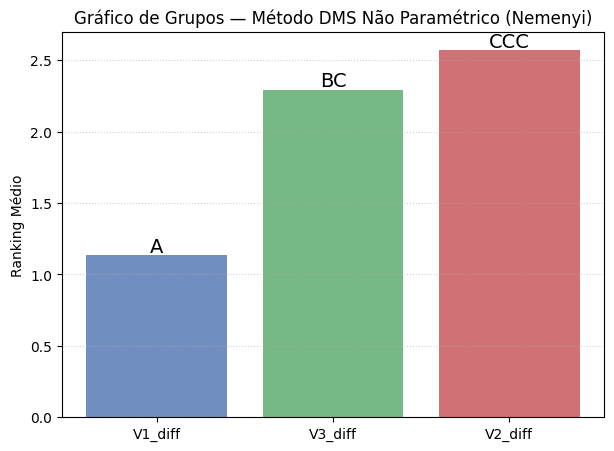

In [30]:
# ===============================
# 5. GRÁFICO DE "LETRAS" (CONNECTING LETTERS)
# ===============================

df = df_diff.copy()
k = df.shape[1]
n = df.shape[0]

rankings = df.rank(axis=1)
R = rankings.mean()

q_crit = {3: 2.343, 4: 2.569, 5: 2.728}
q = q_crit[k]
CD = q * np.sqrt(k*(k+1)/(6*n))

# Ordenar por ranking médio
ordem = R.sort_values()
grupos = ordem.index.tolist()

# Atribuição das letras
letras = {g: [] for g in grupos}
letra_atual = "A"

for i, g1 in enumerate(grupos):
    letras[g1].append(letra_atual)
    for j in range(i+1, len(grupos)):
        g2 = grupos[j]
        if abs(R[g2] - R[g1]) > CD:
            letra_atual = chr(ord(letra_atual) + 1)
            letras[g2].append(letra_atual)
        else:
            letras[g2].append(letra_atual)

print("===== GRUPOS COM LETRAS =====")
for k in letras:
    print(f"{k}: {''.join(letras[k])}")

# Gráfico simples
plt.figure(figsize=(7,5))
plt.bar(ordem.index, ordem.values,
        color=["#4C72B0","#55A868","#C44E52"], alpha=0.8)

for i, g in enumerate(ordem.index):
    plt.text(i, ordem[g] + 0.02, ''.join(letras[g]),
             ha='center', fontsize=14)

plt.ylabel("Ranking Médio")
plt.title("Gráfico de Grupos — Método DMS Não Paramétrico (Nemenyi)")
plt.grid(axis="y", linestyle=":", alpha=0.6)

plt.show()


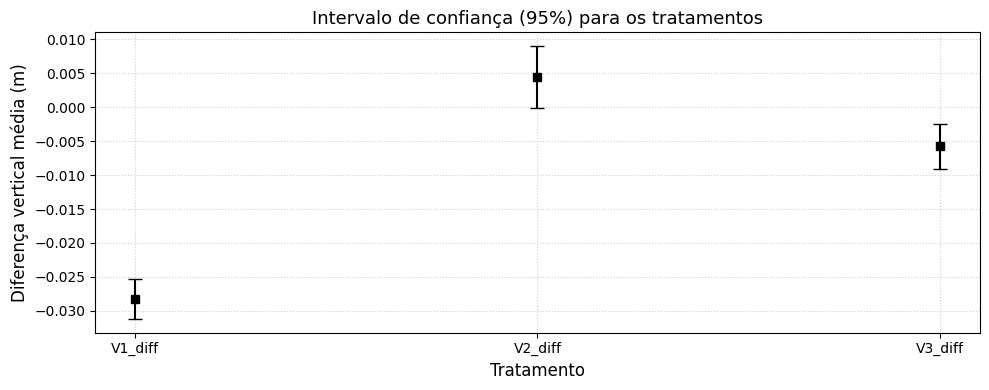

In [14]:
# ============================================
# GRÁFICO DE MÉDIAS COM INTERVALO DE CONFIANÇA
# Formato inspirado no artigo (tipo Fig. 3)
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

df = df_diff.copy()

# --------------------------------------------
# Função para intervalo de confiança 95%
# IC = média ± t * (desvio_padrao / sqrt(n))
# --------------------------------------------
def IC95(vetor):
    vetor = np.array(vetor)
    mean = np.mean(vetor)
    sd = np.std(vetor, ddof=1)
    n = len(vetor)
    t = 1.96   # aproximação para 95% (n grande)
    erro = t * sd / sqrt(n)
    return mean, erro


# Cálculo para cada conjunto
tratamentos = df.columns.tolist()
medias = []
erros  = []

for col in tratamentos:
    m, e = IC95(df[col])
    medias.append(m)
    erros.append(e)


# --------------------------------------------
# Plot
# --------------------------------------------
plt.figure(figsize=(10,4))

x = np.arange(len(tratamentos))

plt.errorbar(
    x, medias, yerr=erros,
    fmt='s', markersize=6, linewidth=1.5,
    capsize=5, color='black'
)

plt.xticks(x, tratamentos)
plt.xlabel("Tratamento", fontsize=12)
plt.ylabel("Diferença vertical média (m)", fontsize=12)

plt.grid(True, linestyle=':', alpha=0.6)

plt.title("Intervalo de confiança (95%) para os tratamentos", fontsize=13)
plt.tight_layout()
plt.show()
